In [1]:
import numpy as np
import pandas as pd

def parse_coords(coords):
    return [float(x) for x in coords.split('-')]

def get_x(filename):
    x_pd = pd.read_csv(filename, header=None)
    x_pd_parsed = x_pd.applymap(parse_coords)
    x_np = x_pd_parsed.to_numpy()
    return np.array([[x for x in y] for y in x_np[:]])

def get_y(filename):
    x_pd = pd.read_csv(filename, header=None)
    return x_pd.to_numpy()

In [2]:
X = get_x('data/train_x.csv')
y = get_y('data/train_y.csv').reshape((-1))

X_test = get_x('data/test_x.csv')
y_test = get_y('data/test_y.csv').reshape((-1))

In [3]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches




def plot_path(verts, ax):
    ax.axis('off')
    
    xs, ys = zip(*verts)
    ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

    i=0
    for x,y in verts:
        rand_x,rand_y = np.random.rand(2)-0.5
        ax.text(x+rand_x, y+rand_y, 'P'+str(i))
        i += 1

    min_x,max_x = np.min(verts[:,0]),np.max(verts[:,0])
    min_y,max_y = np.min(verts[:,1]),np.max(verts[:,1])


    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)
    
def plot_many(samples, labels=None):
    n = (samples.shape[0])
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 8
        rows = int((n+cols-1)/cols)
        fig = plt.figure(figsize=(cols * 3, rows * 3))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if labels is not None :
            sub.title.set_text('y={0}'.format(labels[i]))
        else :
            sub.title.set_text('nolabel')
        plot_path(samples[i], sub)

n = 10
plot_many(X[:n], y[:n])

In [4]:
import torch.nn as nn
import torch
import torch.nn.functional as F

torch.manual_seed(1)

class Net(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, output_dim)

    def forward(self, sentence):
        hidden = (torch.randn(1,sentence.shape[0],  self.hidden_dim), torch.randn(1,sentence.shape[0], self.hidden_dim))
        lstm_out, _ = self.lstm(sentence, hidden)
#         print(lstm_out.shape)
        lstm_out = lstm_out[:,-1,:]
#         print(lstm_out.shape)
        tag_space = self.hidden2tag(lstm_out)
#         print(tag_space.shape)
        tag_scores = F.log_softmax(tag_space, dim=1)
#         print(tag_scores.shape)
        return tag_scores

n_hidden = 256
n_letters = 2
n_categories = 4

model = Net(n_letters, n_hidden, n_categories)

In [5]:
from torchvision.transforms.functional import to_tensor


Xt = to_tensor(X).float().permute(1,2,0)
print(Xt.shape)
inp = Xt[0:2,:,:]
print(inp.shape[1])
# print(inp.shape)
output = model(inp)
print(output)

torch.Size([9000, 5, 2])
5
tensor([[-1.4309, -1.3221, -1.3003, -1.5056],
        [-1.4772, -1.3053, -1.3434, -1.4285]], grad_fn=<LogSoftmaxBackward>)


In [6]:
import torch.optim as optim

loss_function = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.004)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    row = Xt[0:1]
    sentence_in = row
    tag_scores = model(sentence_in)
    print(tag_scores)
    targets = torch.tensor(y[0:1], dtype=torch.long)
    print(targets)
    los = loss_function(tag_scores, targets)
    print(los)

loss_log = []


    

tensor([[-1.4537, -1.3515, -1.2742, -1.4793]])
tensor([0])
tensor(1.4537)


first step done
epoch 0 loss 7254.806714057922
epoch 1 loss 7172.887195944786
epoch 2 loss 7066.885206699371
epoch 3 loss 7073.397288322449
epoch 4 loss 6949.938957095146
epoch 5 loss 6934.847062826157
epoch 6 loss 6872.2979056835175
epoch 7 loss 6834.140741229057
epoch 8 loss 6806.653291583061
epoch 9 loss 6735.151392817497
epoch 10 loss 6773.3903431892395
epoch 11 loss 6770.376065969467
epoch 12 loss 6720.105847120285
epoch 13 loss 6713.281964063644
epoch 14 loss 6700.487424731255
epoch 15 loss 6682.895003557205
epoch 16 loss 6665.949520468712
epoch 17 loss 6663.55948984623
epoch 18 loss 6619.430344104767
epoch 19 loss 6583.683251738548
epoch 20 loss 6578.1643760204315
epoch 21 loss 6578.550233244896
epoch 22 loss 6560.445676445961
epoch 23 loss 6571.67999625206
epoch 24 loss 6533.504077792168
epoch 25 loss 6520.837415456772
epoch 26 loss 6529.36961889267
epoch 27 loss 6520.620376467705
epoch 28 loss 6506.507440209389
epoch 29 loss 6478.392975926399
epoch 30 loss 6482.143964767456
ep

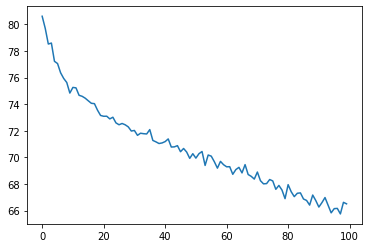

In [8]:

optimizer = optim.Adam(model.parameters(), lr=0.01)
batch_size = 100
batches = int(len(Xt)/batch_size)

for i in range(batches) :
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        n = i * batch_size
        sentence_in = Xt[n:n+batch_size,:4,:]
        targets = torch.tensor(y[n:n+batch_size], dtype=torch.long)
        
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
#         acc_loss += loss.item()
        loss.backward()
        optimizer.step()

print("first step done")


for epoch in range(100):  # again, normally you would NOT do 300 epochs, it is toy data
    acc_loss = 0
    
    for i in range(batches) :
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        n = i * batch_size
        sentence_in = Xt[n:n+batch_size]
        targets = torch.tensor(y[n:n+batch_size], dtype=torch.long)
        
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        acc_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_log.append(acc_loss)
    if epoch % 10 == 0 :
        print("epoch", epoch, "loss", acc_loss*batches)


plt.figure()
plt.plot(loss_log, label='truncated')

In [11]:
# See what the scores are after training
with torch.no_grad():
    row = Xt[:1]
    sentence_in = row
    tag_scores = model(sentence_in)
    print(tag_scores)
    targets = torch.tensor(y[0:1], dtype=torch.long)
    print(targets)
    los = loss_function(tag_scores, targets)
    print(los)

tensor([[-0.1971, -2.4941, -2.3861, -5.4374]])
tensor([0])
tensor(0.1971)


In [9]:
def accuracy(testX, testY):
# Go through a bunch of examples and record which are correctly guessed
    with torch.no_grad():
        tag_scores = model(testX)
        print(tag_scores.shape)
        targets = torch.tensor(testY, dtype=torch.long)
        print(targets.shape)
            
    acc = ((tag_scores.argmax(dim=1) == targets).sum().float()/float(testY.shape[0])).item()
    print('acc:', acc)
    return acc

accuracy(Xt, y)

torch.Size([9000, 4])
torch.Size([9000])
acc: 0.7017777562141418


0.7017777562141418

In [33]:
with torch.no_grad():
        tag_scores = model(Xt)
        print(tag_scores.shape)
        print(tag_scores.argmax(dim=1).shape)
        targets = torch.tensor(y, dtype=torch.long)
        print(targets.shape)
        print(tag_scores.argmax(dim=1)[:5])
        print(targets[:5])
        print((tag_scores.argmax(dim=1) == targets)[:5].sum()/)

torch.Size([9000, 4])
torch.Size([9000])
torch.Size([9000])
tensor([0, 1, 3, 2, 1])
tensor([0, 1, 3, 3, 3])
tensor(0.6000)


In [16]:
accuracy(Xt, y)

torch.Size([9000, 4])
torch.Size([9000])
acc: 0.6769999861717224


0.6769999861717224

In [10]:
X_test_tens = to_tensor(X_test).float().permute(1,2,0)
accuracy(X_test_tens, y_test)

torch.Size([1000, 4])
torch.Size([1000])
acc: 0.6549999713897705


0.6549999713897705